In [1]:
from keras.layers import Conv3D, MaxPooling3D, Dropout, Dense, Flatten, Activation, BatchNormalization
from openbabel import pybel
import numpy as np
import keras
import tensorflow as tf
import os

In [2]:
#Converts the protein-ligand complexes into 3D voxel images. 
class Feature_extractor():
    def __init__(self):
        self.atom_codes = {}
        #'others' includs metal atoms and B atom. There are few B atoms in protein-ligand complexes. 
        others = ([3,4,5,11,12,13]+list(range(19,32))+list(range(37,51))+list(range(55,84)))
        #C and N atoms can be hybridized in three ways. S atom can be hybridized in two ways. 
        #Hydrogen atom is also considered for feature extraction.
        atom_types = [1,(6,1),(6,2),(6,3),(7,1),(7,2),(7,3),8,15,(16,2),(16,3),34,[9,17,35,53],others]
      
        for i, j in enumerate(atom_types):
            if type(j) is list:
                for k in j:
                    self.atom_codes[k] = i
                
            else:
                self.atom_codes[j] = i              
        
        self.sum_atom_types = len(atom_types)
        
    #Onehot encoding of each atom. The atoms in protein or ligand are treated separately.
    def encode(self, atomic_num, molprotein):
        encoding = np.zeros(self.sum_atom_types*2)
        if molprotein == 1:
            encoding[self.atom_codes[atomic_num]] = 1.0
        else:
            encoding[self.sum_atom_types+self.atom_codes[atomic_num]] = 1.0
        
        return encoding
    
    #Get atom coords and atom features from the complexes.   
    def get_features(self, molecule, molprotein):
        coords = []
        features = []
            
        for atom in molecule:
            coords.append(atom.coords)
            if atom.atomicnum in [6,7,16]:
                atomicnum = (atom.atomicnum,atom.hyb)
                features.append(self.encode(atomicnum,molprotein))
            else:
                features.append(self.encode(atom.atomicnum,molprotein))
        
        coords = np.array(coords, dtype=np.float32)
        features = np.array(features, dtype=np.float32)
        
        return coords, features  

    #Generate 3d grid. Each grid represents a voxel. Each voxel represents the atom in it by onehot encoding of atom type.
    def grid(self,coords, features):
        assert coords.shape[1] == 3
        assert coords.shape[0] == features.shape[0]  

        
        grid=np.zeros((1,20,20,20,features.shape[1]),dtype=np.float32)
        x=y=z=np.array(range(-10,10),dtype=np.float32)+0.5
        for i in range(len(coords)):
            coord=coords[i]
            tmpx=abs(coord[0]-x)
            tmpy=abs(coord[1]-y)
            tmpz=abs(coord[2]-z)
            if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                grid[0,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]
                    
        return grid

In [3]:
def get_grid(protein, ligand):
    Feature = Feature_extractor()
    coords1, features1 = Feature.get_features(protein,1)
    coords2, features2 = Feature.get_features(ligand,0)
    
    center=(np.max(coords2,axis=0)+np.min(coords2,axis=0))/2
    coords=np.concatenate([coords1,coords2],axis = 0)
    features=np.concatenate([features1,features2],axis = 0)
    assert len(coords) == len(features)
    coords = coords-center
    grid=Feature.grid(coords,features)
    
    return grid

In [4]:
def build_model():
    model = keras.Sequential([
    Conv3D(7,kernel_size=(1,1,1),input_shape=(20,20,20,28),strides=(1,1,1)),
    BatchNormalization(),  
    Activation('relu'),
    Conv3D(7,kernel_size=(3,3,3)),
    BatchNormalization(),  
    Activation('relu'),
    Conv3D(7,kernel_size=(3,3,3)),
    BatchNormalization(),
    Activation('relu'),
    Conv3D(28,kernel_size=(1,1,1)),
    BatchNormalization(),  
    Activation('relu'),
    Conv3D(56,kernel_size=(3,3,3),padding='same'),
    BatchNormalization(),  
    Activation('relu'),
    MaxPooling3D(pool_size=2),
    Conv3D(112,kernel_size=(3,3,3),padding='same'),
    BatchNormalization(),  
    Activation('relu'),
    MaxPooling3D(pool_size=2),
    Conv3D(224,kernel_size=(3,3,3),padding='same'),
    BatchNormalization(),  
    Activation('relu'),
    MaxPooling3D(pool_size=2),
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dense(1)])

    model.load_weights('weights4_22_112-0.0083.h5')
    return model
    

In [5]:
def predict(protein, ligand, model):
    grid = get_grid(protein, ligand)
    result = model.predict(grid) * 15
    return result

In [6]:
model = build_model()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 20, 20, 7)     203       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 20, 7)     28        
_________________________________________________________________
activation (Activation)      (None, 20, 20, 20, 7)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 18, 18, 18, 7)     1330      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 18, 7)     28        
_________________________________________________________________
activation_1 (Activation)    (None, 18, 18, 18, 7)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 16, 16, 7)     1

In [8]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [9]:
last_conv_layer_name = "activation_6"

In [10]:
ligand = next(pybel.readfile('mol2','trainset\\1a28\\1a28_ligand.mol2'))
protein = next(pybel.readfile('pdb','trainset\\1a28\\1a28_protein.pdb'))

In [11]:
grid = get_grid(protein, ligand)

In [12]:
grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("activation_6").output, model.output]
    )

In [13]:
with tf.GradientTape() as tape:
    last_conv_layer_output, output = grad_model(grid)

In [14]:
grads = tape.gradient(output, last_conv_layer_output)

In [15]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

In [16]:
last_conv_layer_output = last_conv_layer_output[0]

In [17]:
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

In [19]:
heatmap = tf.squeeze(heatmap)

In [152]:
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

In [20]:
heatmap = heatmap / tf.math.reduce_max(heatmap)

In [21]:
heatmap = heatmap.numpy()

In [22]:
heatmap

array([[[-0.39248613, -0.4357882 , -0.4137878 , -1.5043266 ],
        [ 0.47820115,  0.33769745,  0.36456168, -0.22016513],
        [ 0.46069115, -0.53211004, -0.31809974, -0.53125745],
        [-0.23529987, -0.957217  , -0.6555989 , -1.0591389 ]],

       [[-0.12733781,  0.6390743 ,  0.44865325, -0.7442978 ],
        [ 0.33705255,  0.45566487,  0.44803193,  0.13451192],
        [ 0.05267283, -0.25774288,  0.64006   , -1.0166458 ],
        [ 0.18651274, -0.12751545, -0.2844999 , -1.1745152 ]],

       [[-0.5093245 , -0.2558239 ,  0.21839856, -0.82807344],
        [-0.94437456,  0.30465683,  0.64415956, -0.21130039],
        [-0.00361057,  1.        ,  0.03871335, -0.552239  ],
        [-0.43802255, -0.04203737, -0.39058882, -1.810787  ]],

       [[-0.47841546, -0.1399935 , -0.27553463, -0.8160459 ],
        [-0.39643782,  0.65422636,  0.6199388 , -0.43379897],
        [-0.9130659 , -0.06331265, -0.12254246,  0.02393675],
        [-1.3012571 , -1.5676879 , -1.4945023 , -1.6407801 ]]],


In [24]:
def resize(grid, result_shape):
    m1,m2,m3 = grid.shape
    n1,n2,n3 = result_shape
    result = np.zeros((result_shape))
    
    g = np.zeros((m1+2,m2+2,m3+2))    #grid_new
    for i in range(m1):
        for j in range(m2):
            for k in range(m3):
                g[i+1,j+1,k+1] = grid[i,j,k]
    
    for i in range(n1):
        for j in range(n2):
            for k in range(n3):
                x = (i+0.5)*m1/n1-0.5+1
                y = (j+0.5)*m2/n2-0.5+1
                z = (k+0.5)*m3/n3-0.5+1
                
                u1 = int(x)
                v1 = x - u1
                u2 = int(y)
                v2 = y -u2
                u3 = int(z)
                v3 = z - u3

                f = (1-v1)*(1-v2)*(1-v3)*g[u1,u2,u3] + (1-v1)*(1-v2)*v3*g[u1,u2,u3+1] + (1-v1)*v2*(1-v3)*g[u1,u2+1,u3] + (1-v1)*v2*v3*g[u1,u2+1,u3+1] + v1*(1-v2)*(1-v3)*g[u1+1,u2,u3] + v1*(1-v2)*v3*g[u1+1,u2,u3+1] + v1*v2*(1-v3)*g[u1+1,u2+1,u3] + v1*v2*v3*g[u1+1,u2+1,u3+1]
                
                result[i,j,k] = f
    
    return result              
                
                

In [ ]:
new = resize(heatmap, (20,20,20))

In [26]:
import pickle 

In [27]:
with open('1a28_grid.pkl', 'wb') as f:
    pickle.dump(grid,f)

In [28]:
with open('1a28_heatmap.pkl', 'wb') as f:
    pickle.dump(new,f)

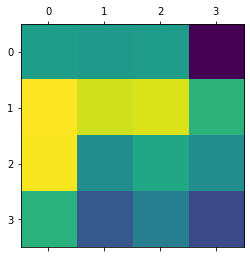

In [29]:
plt.matshow(heatmap[0])

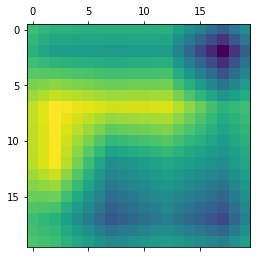

In [30]:
plt.matshow(new[0])

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
df = pd.DataFrame(columns = ['Epoch','loss','val_loss'])

In [47]:
with open('cnnprerms4_95new2_22.log', 'r') as f:
    for line in f.readlines():
        if line.startswith('Epoch'):
            m = line[5:].strip().split('/')[0]
        if line.lstrip().startswith('717/717') and line.find('val_loss') != -1:
            i1 = line.find('loss')
            i2 = line.find('- mae')
            i3 = line.find('val_loss')
            i4 = line.find('- val_mae')
            n = line[i1+5:i2].strip()
            q = line[i3+9:i4].strip()
            df.loc[df.shape[0]] = dict(zip(df.columns, [m,n,q]))

In [50]:
df.to_csv('cnn2_f1.csv',index=None)